# Concealed Pistol Detection

### Imports

In [1]:
#imports for neural network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchsummary import summary

#imports for vision
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

#imports for preparing dataset
import os
import zipfile
#from google.colab import files
#from google.colab import drive

#imports for visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Preparing Dataset

In [2]:
#applying a transformation to the entire dataset, standardizing it
#reshapes the image to guarantee a 256 size
#grayscales the image
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

#relative directory path
#ImageFolder sets classes based on folder names
dataset_dir = "Data/ConcealedPistolDataset/"
dataset = datasets.ImageFolder(root = dataset_dir, transform = transform)

#initialize train, validation, and test sets
train_size = int(0.8 * len(dataset))              #80% for training
val_size = int(0.1 * len(dataset))                #10% for validation
test_size = len(dataset) - train_size - val_size  #10% (remainder) for test
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

#print sizes of datasets
print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

#set the dataloaders to use the datasets
batch_size = 32
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#variable to define number of classes
num_classes = 2


Train size: 286
Valid size: 35
Test size: 37


### Setting device to GPU 

In [3]:
#setting device to gpu if availible
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

#confirm device
print("Device:", device)


Device: cpu


### Visualizing the transformed dataset

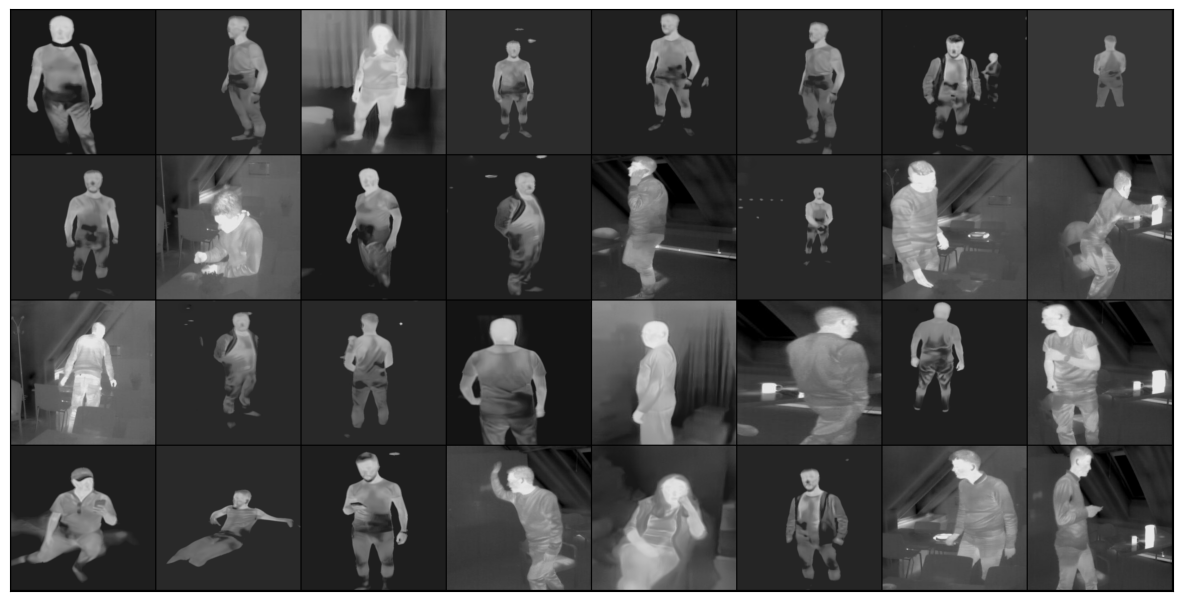

In [4]:
#plotting a grid of a single batch
def show_batch(dataLoader):
    for images, labels in dataLoader:
        fig, ax = plt.subplots(figsize = (15, 10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 8).permute(1, 2, 0))
        break

show_batch(train_dl)

### Defining the model

In [5]:
#definition for a CNN
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        #model takes input of 256 x 256 x 1
        #make sure in_channels aligns with out_channels from the previous layer

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2,2)

        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2,2)

        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool4 = nn.MaxPool2d(2,2)

        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        self.bn5 = nn.BatchNorm2d(128)
        self.pool5 = nn.MaxPool2d(2,2)

        #8 x 8 x 128 comes from sizing, the pool in each layer cut dimensionality in half, 128 is out channels
        self.fc1 = nn.Linear(in_features = (8 * 8 * 128), out_features = 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        self.fc2 = nn.Linear(in_features = 64, out_features = num_classes)


    def forward(self, input):
        #forward pass first block
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu(output)
        outputPool1 = self.pool1(output)

        #forward pass second block
        output = self.conv2(outputPool1)
        output = self.bn2(output)
        output = self.relu(output)
        outputPool2 = self.pool2(output)

        #forward pass third block
        output = self.conv3(outputPool2)
        output = self.bn3(output)
        output = self.relu(output)
        outputPool3 = self.pool3(output)

        #forward pass fourth block
        output = self.conv4(outputPool3)
        output = self.bn4(output)
        output = self.relu(output)
        outputPool4 = self.pool4(output)

        #forward pass fifth block
        output = self.conv5(outputPool4)
        output = self.bn5(output)
        output = self.relu(output)
        outputPool5 = self.pool5(output)


        #forward pass flattening
        output = outputPool5.view(-1, 128 * 8 * 8)

        #forward pass fully connected layers
        output = self.fc1(output)
        output = self.relu(output)
        output = self.dropout(output)

        output = self.fc2(output)

        return output

model = Network().to(device)

#channels, height, width
summary(model,(1, 256, 256))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
         MaxPool2d-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 32, 128, 128]           9,248
       BatchNorm2d-6         [-1, 32, 128, 128]              64
              ReLU-7         [-1, 32, 128, 128]               0
         MaxPool2d-8           [-1, 32, 64, 64]               0
            Conv2d-9           [-1, 64, 64, 64]          18,496
      BatchNorm2d-10           [-1, 64, 64, 64]             128
             ReLU-11           [-1, 64, 64, 64]               0
        MaxPool2d-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,928
      BatchNorm2d-14           [-1, 64,

### Defining Loss and Optimizer


In [6]:
#cross entropy loss
criterion = nn.CrossEntropyLoss()
#adam optimizer
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

### Training loop of the model

In [8]:
#number of epochs and early stopping
epochs = 20
early_stopping_patience = 5
early_stopping_counter = 0

#using validation loss as the best model
best_val_loss = float('inf')
best_epoch = 0

#arrays to save each metric during training
train_loss_values = []
train_acc_values = []

val_loss_values = []
val_acc_values = []

#training loop
for epoch in range(epochs):
    #turn on training mode
    model.train()

    #storing loss and accuracy per batch
    train_losses = []
    train_acc = []

    for data, label in train_dl:
        #moving data to the right device
        data = data.to(device)
        label = label.to(device)

        #clear gradients, forward pass, loss, backward and update
        optimizer.zero_grad()
        output = model(data)
        loss = criterion (output, label)
        loss.backward()
        optimizer.step()

        #storing loss and accuracy over the batch
        accuracy = (output.argmax(dim = 1) == label).float().mean().item()
        train_losses.append(loss.item())
        train_acc.append(accuracy)
    
    #average loss and acc over the epoch
    current_epoch_loss = sum(train_losses) / len(train_losses)
    current_epoch_acc = sum(train_acc) / len(train_acc)

    #storing current epoch into overall loss and acc
    train_loss_values.append(current_epoch_loss)
    train_acc_values.append(current_epoch_acc)

    #validation testing
    #turn on evaluation mode
    model.eval()

    #storing loss and accuracy 
    val_losses = []
    val_acc = []
    
    #disabling gradient tracking
    with torch.no_grad():
        for data, label in val_dl:
            #moving data to the right device
            data = data.to(device)
            label = label.to(device)

            #running forward pass and calculating loss
            val_output = model(data)
            val_loss = criterion(val_output, label)

            #storing loss and accuracy
            accuracy = (val_output.argmax(dim = 1) == label).float().mean().item()
            val_losses.append(val_loss.item())
            val_acc.append(accuracy)

    #averaging loss and accuracy 
    current_epoch_val_loss = sum(val_losses) / len(val_losses)
    current_epoch_val_acc = sum(val_acc) / len(val_acc)

    #storing current epoch into overall
    val_loss_values.append(current_epoch_val_loss)
    val_acc_values.append(current_epoch_val_acc)

    #checking for model improvement
    if current_epoch_val_loss < best_val_loss:
        #if best epoch, save it
        torch.save(model.state_dict(), "best_concealed_model.pth")
        
        #best epoch information
        best_val_loss = current_epoch_val_loss
        best_epoch = epoch + 1
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    #output current epoch information
    print(f"Epoch: {epoch+1}")
    print(f"Training Accuracy: {current_epoch_acc:.3f}, Validation Accuracy: {current_epoch_val_acc:.3f}")
    print(f"Training Loss: {current_epoch_loss:.3f}, Validation Loss: {current_epoch_val_loss:.3f}")
    print(f"Current Best Epoch: {best_epoch}\n")

    #stop if not improving
    if early_stopping_counter >= early_stopping_patience:
        print(f"Stopping early after {early_stopping_patience} epochs with no improvement")
        break


Epoch: 1
Training Accuracy: 0.993, Validation Accuracy: 0.984
Training Loss: 0.025, Validation Loss: 0.021
Current Best Epoch: 1

Epoch: 2
Training Accuracy: 0.990, Validation Accuracy: 0.984
Training Loss: 0.025, Validation Loss: 0.020
Current Best Epoch: 2

Epoch: 3
Training Accuracy: 0.993, Validation Accuracy: 0.984
Training Loss: 0.019, Validation Loss: 0.022
Current Best Epoch: 2

Epoch: 4
Training Accuracy: 1.000, Validation Accuracy: 0.984
Training Loss: 0.011, Validation Loss: 0.029
Current Best Epoch: 2

Epoch: 5
Training Accuracy: 0.997, Validation Accuracy: 0.984
Training Loss: 0.011, Validation Loss: 0.023
Current Best Epoch: 2

Epoch: 6
Training Accuracy: 1.000, Validation Accuracy: 1.000
Training Loss: 0.009, Validation Loss: 0.012
Current Best Epoch: 6

Epoch: 7
Training Accuracy: 1.000, Validation Accuracy: 1.000
Training Loss: 0.008, Validation Loss: 0.010
Current Best Epoch: 7

Epoch: 8
Training Accuracy: 1.000, Validation Accuracy: 1.000
Training Loss: 0.004, Valida

### Plotting Model Training Results 

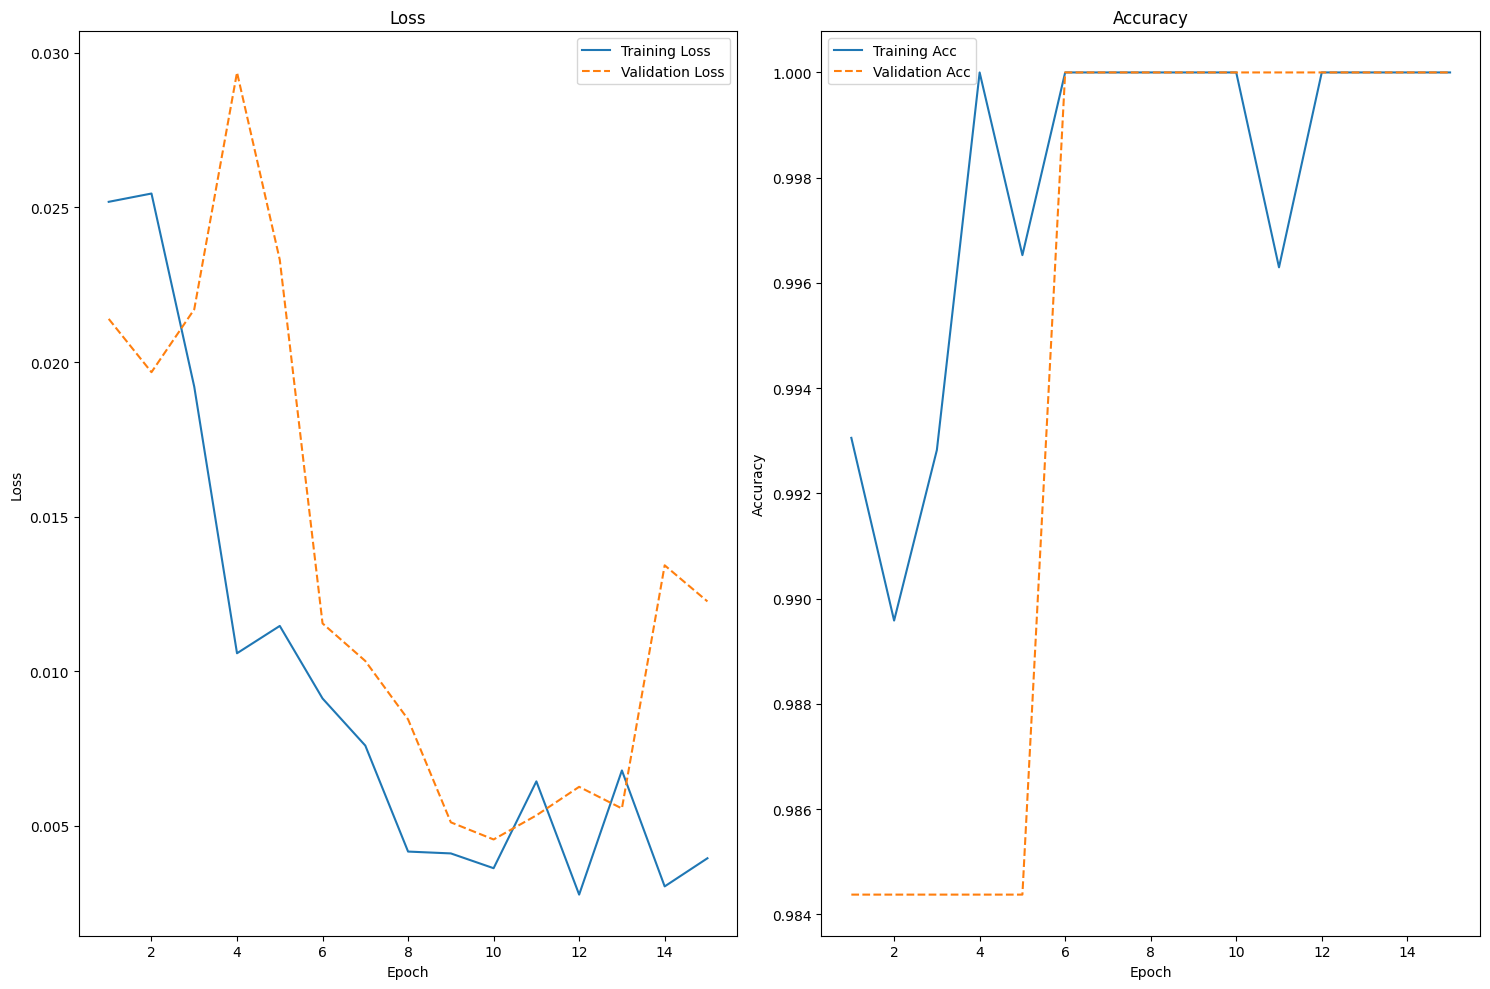

In [9]:
#epoch count
epoch_count = []
for i in range(len(train_loss_values)):
    epoch_count.append(i + 1)

#setting figure size
plt.figure(figsize = (15, 10))

#plotting loss
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(epoch_count, train_loss_values, label='Training Loss')
plt.plot(epoch_count, val_loss_values, label='Validation Loss', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

#plotting accuracy
plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(epoch_count, train_acc_values, label='Training Acc')
plt.plot(epoch_count, val_acc_values, label='Validation Acc', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

#showing figures
plt.tight_layout()
plt.show()

### Testing Model


In [10]:
#loading best saved model
model.load_state_dict(torch.load('best_concealed_model.pth', weights_only = True))

#set to evaluation mode
model.eval() 

#disabling gradient tracking
with torch.no_grad(): 
    total_accuracy = 0.0
    total_test_loss = 0.0
    num_batches = len(test_dl)

    for data, label in test_dl:
        #loading data and labels to proper device
        data = data.to(device)
        label = label.to(device)

        #forward pass, loss, accuracy calculation
        output = model(data)
        loss = criterion(output, label)
        accuracy = (output.argmax(dim = 1) == label).float().mean()

        total_test_loss += loss.item()
        total_accuracy += accuracy.item()

    # Calculate the average loss and accuracy over all batches
    avg_loss = total_test_loss / num_batches
    avg_accuracy = total_accuracy / num_batches

    print(f"Test Accuracy: {avg_accuracy:.3f}")
    print(f"Test Loss : {avg_loss:.3f}")

Test Accuracy: 1.000
Test Loss : 0.000


### Testing Model Performance on DIFFERENT dataset
This dataset is from a different source, patched together from multiple other sources.
The purpose of this is testing the generalization of the model on different quality thermal cameras.

In [11]:
#setting different dataset directory
test_dataset_directory = 'Data/ConcealedTestDataset/'
test_dataset = datasets.ImageFolder(root = test_dataset_directory, transform = transform)

#processing data into 32 large batches
batch_size = 32
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#loading best saved model
model.load_state_dict(torch.load('best_concealed_model.pth', weights_only = True))

#set to evaluation mode
model.eval() 

#disabling gradient tracking
with torch.no_grad(): 
    total_accuracy = 0.0
    total_test_loss = 0.0
    num_batches = len(test_dl)

    for data, label in test_dl:
        #loading data and labels to proper device
        data = data.to(device)
        label = label.to(device)

        #forward pass, loss, accuracy calculation
        output = model(data)
        loss = criterion(output, label)
        accuracy = (output.argmax(dim = 1) == label).float().mean()

        total_test_loss += loss.item()
        total_accuracy += accuracy.item()

    # Calculate the average loss and accuracy over all batches
    avg_loss = total_test_loss / num_batches
    avg_accuracy = total_accuracy / num_batches

    print(f"Test Accuracy: {avg_accuracy:.3f}")
    print(f"Test Loss : {avg_loss:.3f}")

FileNotFoundError: [Errno 2] No such file or directory: 'Data/ConcealedTestDataset/'